<a href="https://colab.research.google.com/github/koseemre/ITU-Coding-and-Projects/blob/master/ML/AAPL_LSTM_indicators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import math
import pandas as pd
import numpy as np

from IPython.display import display
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 12)

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
!pip install quandl
import quandl
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import sys


In [0]:
quandl.ApiConfig.api_key = 't7wV_HsxHcR6HfpViu-K'

In [0]:
def get_stock_data(stock_name, normalize=True, ma=[]):
    
    df = quandl.get_table('WIKI/PRICES', ticker = stock_name)
    df.drop(['ticker', 'adj_open', 'adj_high', 'adj_low', 'adj_close', 'ex-dividend', 'adj_volume', 'split_ratio'], 1, inplace=True)
    df.set_index('date', inplace=True)
    
    
          
    # Move Adj Close to the rightmost for the ease of training
    adj_close = df['close']
    df.drop(labels=['close'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)
      
    return df

In [0]:
#ds = get_stock_data('AAPL', ma=[50, 100, 200])
ds = get_stock_data('AAPL')



In [0]:
dataset = ds.iloc[:, [0,1,2,3,4]].values #open high low volume close
print(dataset.shape)


(9400, 5)


In [0]:
w, h = 1, ds.shape[0];
onBalanceVolume = [[0 for x in range(w)] for y in range(h)]
onBalanceVolume[0][0]=dataset[0][3]

for i in range(1, dataset.shape[0]):
  if dataset[i][4] > dataset[i-1][4]:
    onBalanceVolume[i][0] = onBalanceVolume[i-1][0] + dataset[i][3]
  elif dataset[i][4] <  dataset[i-1][4]:  
    onBalanceVolume[i][0] = onBalanceVolume[i-1][0] - dataset[i][3]
  else:
    onBalanceVolume[i][0] = onBalanceVolume[i-1][0]
    

o_b_v_array = np.asarray(onBalanceVolume)

In [0]:
#cci implementation
typPrices=[]
MDar = []
cci = []

def movingAverage(values,window):
    weigths = np.repeat(1.0, window)/window
    smas = np.convolve(values, weigths, 'valid')
    return smas # as a numpy array

tf = 14
sma = 20
i  = 0
while i < dataset.shape[0]:
  tp = (dataset[i][1] + dataset[i][2] + dataset[i][4])/3
  typPrices.append(tp)
  i = i+1
  
SMATP = movingAverage(typPrices,sma)
typPrices =  typPrices[sma-1:] 


In [0]:

y = tf
while y < len(SMATP):
  considerationTP = typPrices[y-tf:y]
  considerationSMATP= SMATP[y-tf:y]
  MDs = 0
  z=0
  while z < len(considerationTP):
        curMD = abs(considerationTP[z] - considerationSMATP[z])
        MDs += curMD
        z += 1
  MD = MDs/tf
  MDar.append(MDs)
  
  y+=1  



typPrices = typPrices [14:]
SMATP =SMATP [14:]
t = 0
while t < len(SMATP):
    ccis = (typPrices[t]-SMATP[t]) / (0.015*MDar[t])
    cci.append(ccis)
    t+=1
  

 



In [0]:
print(len(cci))
cci_array = np.asarray(cci)
print(cci_array.shape)

9367
(9367,)


In [0]:

w, h = 1, ds.shape[0]-10;
Rate_of_Change = [[0 for x in range(w)] for y in range(h)]

for i in range(10, dataset.shape[0]):
  roc =  (dataset[i][4]/dataset[i-5][4])*100
  Rate_of_Change[i-10][0] = roc
 

roc_array = np.asarray(Rate_of_Change)


In [0]:

William_R = [[0 for x in range(w)] for y in range(h)]


for i in range(10, dataset.shape[0]):
  highest = 0.0
  lowest = sys.float_info.max 
  closed = dataset[i][4]
  for counter in range(0, 10):
      if dataset[i-counter][1] > highest:
        highest = dataset[i-counter][1]
      if dataset[i-counter][2] < lowest:
        lowest = dataset[i-counter][2] 
  w_r =  (highest-closed)*-100/(highest-lowest)
  William_R[i-10][0] = w_r

  
w_r_array = np.asarray(William_R)

In [0]:
dataset_final = ds.iloc[10:ds.shape[0], [0,3,4]].values
dataset_final = np.c_[ dataset_final, w_r_array] 



print(dataset_final.shape)


(9390, 4)


In [0]:
def unroll(data, sequence_length=24):
 
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

In [0]:
def train_test_split_for_lstm(stocks, prediction_time=1, test_data_size=450, unroll_length=50):

    # training data
    test_data_cut = test_data_size + unroll_length  + 1
    
    x_train = np.matrix(stocks[0:-prediction_time - test_data_cut])
    y_train = np.matrix(stocks[prediction_time:-test_data_cut])

    # test data
    x_test =np.matrix(stocks[0 - test_data_cut:-prediction_time])
    y_test =np.matrix(stocks[prediction_time - test_data_cut:])

    return x_train, x_test, y_train, y_test

In [0]:

def plot_lstm_prediction(actual, prediction, title='APPLE Real vs Prediction', y_label='Price USD', x_label='Trading Days'):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Add labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    # Plot actual and predicted close values

    plt.plot(actual, '#00FF00', label='Real Close')
    plt.plot(prediction, '#0000FF', label='Predicted Close')

    # Set title
    ax.set_title(title)
    ax.legend(loc='upper left')


    plt.show()

In [0]:

scaler  = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset_final)
#test_data_size = int(round(dataset.shape[0]*0.1))
X_train, X_test,y_train, y_test = train_test_split_for_lstm(dataset_scaled, 5)

y_test_dec= scaler.inverse_transform(y_test)
X_train = X_train[:,[0,1,3]]
X_test = X_test[:,[0,1,3]]
unroll_length = 50
X_train = unroll(X_train, unroll_length)
X_test =  unroll(X_test, unroll_length)
y_train = y_train[-X_train.shape[0]:]
y_test = y_test[-X_test.shape[0]:]

y_train = y_train[:, 2]
y_test = y_test[:, 2]

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)

y_test_decimal = np.zeros(shape=(y_test.shape[0]-50,1))
#y_test_decimal= y_test_decimal[0:y_test_decimal.shape[0]-50,2] 

for i in range(y_test_decimal.shape[0]):
    y_test_decimal[i][0] = y_test_dec[i][2]
  
  
print("y_test_decimal", y_test_decimal.shape)


x_train (8834, 50, 3)
y_train (8834, 1)
x_test (446, 50, 3)
y_test (446, 1)
y_test_decimal (396, 1)


In [0]:
def build_model(input_dim, output_dim, return_sequences):
  
    model = Sequential()
    model.add(LSTM(
        input_shape=(None, input_dim),
        units=output_dim,
        return_sequences=return_sequences))

    model.add(Dropout(0.2))

    model.add(LSTM(
        128,
        return_sequences=False))

    model.add(Dropout(0.2))

    model.add(Dense(
        units=1))
    model.add(Activation('linear'))

    return model

In [0]:

print(X_train.shape[-1])
 # build basic lstm model
model = build_model(input_dim = X_train.shape[-1],output_dim = unroll_length, return_sequences=True)

# Compile the model
import time
start = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
print('compilation time : ', time.time() - start)

3
compilation time :  0.06073474884033203


In [0]:
model.fit(
    X_train,
    y_train,
    batch_size=256,
    epochs=30,
    verbose=2)

Epoch 1/30
 - 28s - loss: 0.0076
Epoch 2/30
 - 25s - loss: 0.0015
Epoch 3/30
 - 25s - loss: 0.0013
Epoch 4/30
 - 25s - loss: 0.0013
Epoch 5/30
 - 25s - loss: 0.0013
Epoch 6/30
 - 25s - loss: 0.0012
Epoch 7/30
 - 25s - loss: 0.0012
Epoch 8/30
 - 25s - loss: 0.0012
Epoch 9/30
 - 25s - loss: 0.0011
Epoch 10/30
 - 25s - loss: 0.0011
Epoch 11/30
 - 25s - loss: 0.0010
Epoch 12/30
 - 25s - loss: 0.0011
Epoch 13/30
 - 25s - loss: 0.0010
Epoch 14/30
 - 25s - loss: 9.8811e-04
Epoch 15/30
 - 25s - loss: 0.0011
Epoch 16/30
 - 25s - loss: 0.0011
Epoch 17/30
 - 25s - loss: 0.0011
Epoch 18/30
 - 25s - loss: 0.0011
Epoch 19/30
 - 25s - loss: 0.0010
Epoch 20/30
 - 25s - loss: 0.0010
Epoch 21/30
 - 25s - loss: 9.6523e-04
Epoch 22/30
 - 25s - loss: 0.0010
Epoch 23/30
 - 25s - loss: 9.6000e-04
Epoch 24/30
 - 25s - loss: 8.9917e-04
Epoch 25/30
 - 21s - loss: 9.7656e-04
Epoch 26/30
 - 15s - loss: 0.0010
Epoch 27/30
 - 13s - loss: 9.7945e-04
Epoch 28/30
 - 13s - loss: 9.3734e-04
Epoch 29/30
 - 13s - loss: 0.

In [0]:
predictions = model.predict(X_test)

(446, 1)
(396, 1)
(446, 1)
(446, 1)
(396, 1)


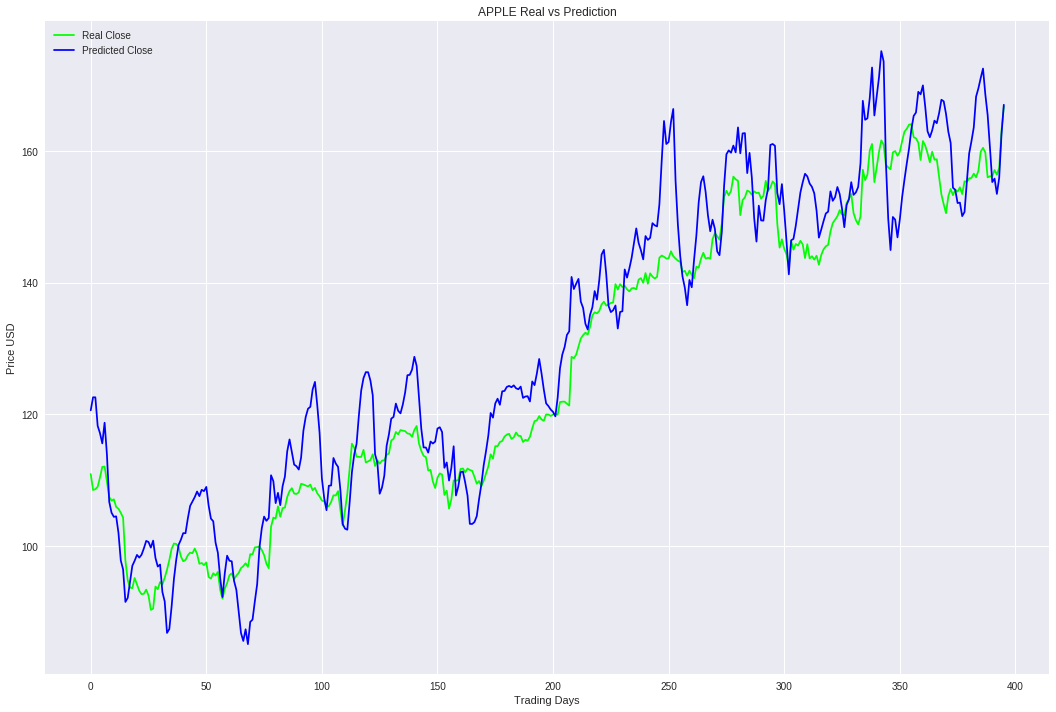

In [0]:
############ Predict & Test the Model ############

print(y_test.shape)
print(y_test_decimal.shape)
print(predictions.shape)
print(y_test.shape)

predicted_decimal = np.zeros(shape=(y_test_decimal.shape))
#print(y_test_temp.shape)
#print(predicted_stock_price.shape)
for i in range(y_test_decimal.shape[0]):
  predicted_decimal[i][0] = ((y_test_decimal[i] * predictions[i])/y_test[i])
                            
print(predicted_decimal.shape)
    
predicted_decimal = np.array(predicted_decimal)
plot_lstm_prediction(y_test_decimal,predicted_decimal)

In [0]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00072114 MSE (0.02685399 RMSE)
Test Score: 0.00011494 MSE (0.01072113 RMSE)


In [0]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_decimal, predicted_decimal)
print(mse)
mse = 0.0
for i in range(y_test_decimal.shape[0]):
  mse = mse + (y_test_decimal[i]-predicted_decimal[i])*(y_test_decimal[i]-predicted_decimal[i])
  
mse = mse / y_test_decimal.shape[0]
print(mse)


50.24937941826609
[50.24937942]
